In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

Config.py using existing local data directory /mnt/disks/disk-1/data/resnet


In [2]:
batch_size = 256
model_name = 'upsampled'

In [3]:
train = pd.read_csv(os.path.join(cfg.csv_dir, 'train_upsampled_multilabel.csv'))
validation = pd.read_csv(os.path.join(cfg.csv_dir, 'validation_multilabel.csv'))
train['imagename'] = train['imagename'].map(lambda x: f"train/{x}")
validation['imagename'] = validation['imagename'].map(lambda x: f"validation/{x}")
df = pd.concat([train, validation])
df.reset_index(inplace=True, drop=True)

assert df.shape[0] == train.shape[0] + validation.shape[0]

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [5]:
src = (ImageList.from_df(path=cfg.img_path, df=df)
       .split_by_idx(valid_idx=range(train.shape[0], df.shape[0]))
       .label_from_df(cols='label', label_delim=' '))

In [6]:
data = (src.transform(tfms, size=224)
        .databunch(bs=batch_size).normalize(imagenet_stats))

In [7]:
assert len(data.valid_ds) == validation.shape[0]
assert len(data.train_ds) == train.shape[0]

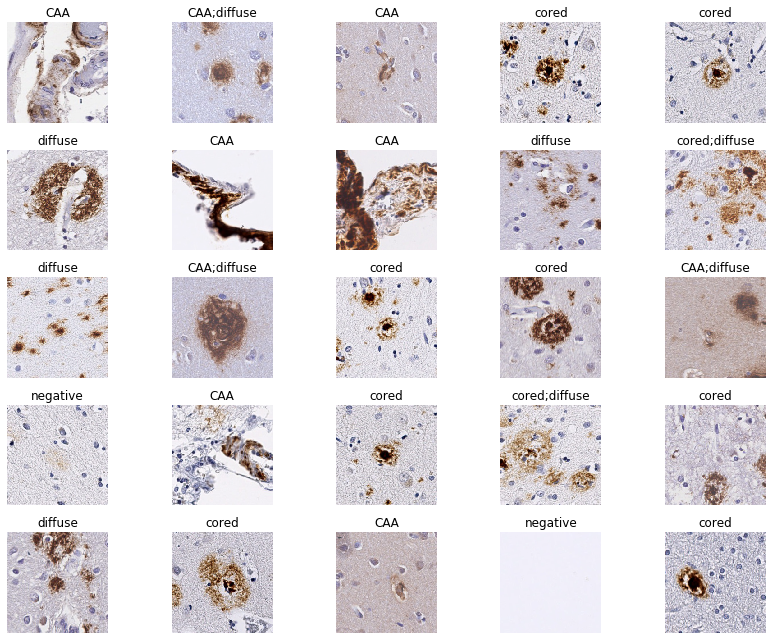

In [8]:
data.show_batch(rows=5, figsize=(12,9))

In [9]:
from fastai.callbacks.tracker import SaveModelCallback, EarlyStoppingCallback

class SaveModelCallbackToDest(SaveModelCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best to specific path."
    def __init__(self,
                 learn:Learner,
                 monitor:str='valid_loss',
                 mode:str='auto',
                 every:str='improvement',
                 name:str='bestmodel',
                 dest:str=None):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name, self.dest = every,name,dest
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
    
    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(os.path.join(self.dest, f'{self.name}_{epoch}'))
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(os.path.join(self.dest, f'{self.name}'))
                


In [10]:
resnet34 = models.resnet34

In [11]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)

In [12]:
learn = cnn_learner(data, resnet34, metrics=[acc_05, f_score])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 44.8MB/s]


In [13]:
learn.data.classes

['CAA', 'cored', 'diffuse', 'negative']

In [14]:
learn = learn.to_fp16()
# This didn't speed up training?

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 2.51E-02


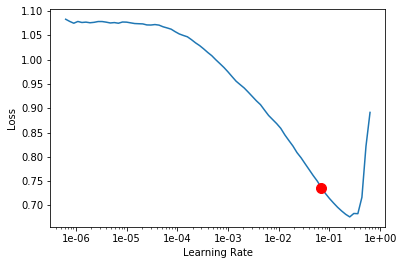

In [22]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [23]:
learn.fit_one_cycle(10, slice(5e-02), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn34-stage1-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.169135,0.177259,0.932503,0.913287,03:23
1,0.163399,0.124916,0.953447,0.940962,03:15
2,0.160639,0.115236,0.962659,0.945789,03:15
3,0.152731,0.127298,0.953998,0.935810,03:16
4,0.144720,0.162030,0.951999,0.934490,03:15
5,0.136020,0.098357,0.966367,0.952848,03:14
6,0.121813,0.152723,0.947856,0.924284,03:14
7,0.112141,0.112560,0.959183,0.942733,03:15
8,0.104214,0.116673,0.958749,0.942486,03:12
9,0.104195,0.118577,0.958488,0.942954,03:14


Better model found at epoch 0 with valid_loss value: 0.17725880444049835.
Better model found at epoch 1 with valid_loss value: 0.12491623312234879.
Better model found at epoch 2 with valid_loss value: 0.11523561179637909.
Better model found at epoch 5 with valid_loss value: 0.09835714101791382.


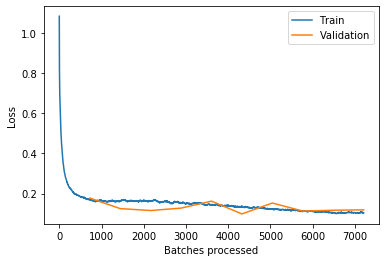

In [24]:
learn.recorder.plot_losses()

In [15]:
model_name = 'rn34-stage1-v1'
learn = learn.load(os.path.join(cfg.models_dir, model_name))

In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.45E-06


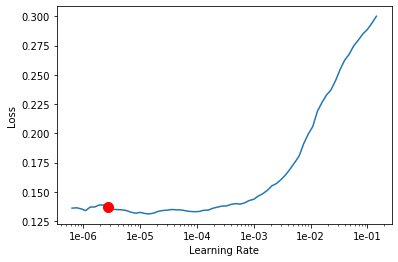

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
learn.fit_one_cycle(20, slice(1e-05, 5e-02/5), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn34-stage2-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.108919,0.122463,0.955678,0.937200,03:28
1,0.102166,0.116250,0.962196,0.947474,03:22
2,0.101258,0.120057,0.959386,0.939691,03:26
3,0.095115,0.099698,0.967816,0.952586,03:25
4,0.092866,0.129597,0.953042,0.934152,03:22
5,0.088571,0.133026,0.952897,0.934953,03:20
6,0.076077,0.124053,0.959328,0.938534,03:19
7,0.069591,0.095044,0.969699,0.954026,03:20
8,0.063452,0.097922,0.968801,0.954155,03:19
9,0.055118,0.119360,0.964195,0.944976,03:20


Better model found at epoch 0 with valid_loss value: 0.1224626749753952.
Better model found at epoch 1 with valid_loss value: 0.11624974757432938.
Better model found at epoch 3 with valid_loss value: 0.09969772398471832.
Better model found at epoch 7 with valid_loss value: 0.09504444152116776.


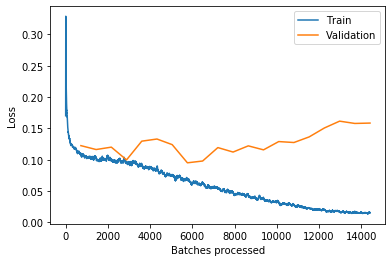

In [19]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.00E-04


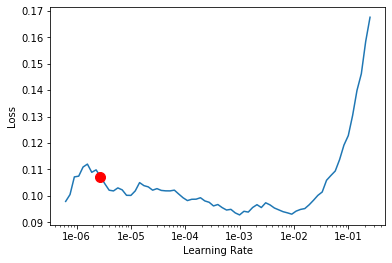

In [37]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [38]:
learn.fit_one_cycle(20, slice(1e-4),
                    callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn34-stage2-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])



epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.104794,0.092774,0.966771,0.954791,02:52
1,0.102496,0.092328,0.967138,0.954934,02:53
2,0.103815,0.092458,0.967313,0.955532,02:52
3,0.106183,0.092026,0.967778,0.954907,02:52
4,0.105525,0.095226,0.967809,0.955453,02:52
5,0.108944,0.091069,0.968289,0.955974,02:53
6,0.107386,0.090891,0.968206,0.955743,02:53
7,0.107190,0.090888,0.968389,0.956133,02:53
8,0.104716,0.091173,0.968198,0.955183,02:53
9,0.099067,0.090859,0.968656,0.955624,02:52


Better model found at epoch 0 with valid_loss value: 0.09277421981096268.
Better model found at epoch 1 with valid_loss value: 0.09232781827449799.
Better model found at epoch 3 with valid_loss value: 0.09202615171670914.
Better model found at epoch 5 with valid_loss value: 0.09106909483671188.
Better model found at epoch 6 with valid_loss value: 0.09089148789644241.
Better model found at epoch 7 with valid_loss value: 0.09088844805955887.
Better model found at epoch 9 with valid_loss value: 0.09085879474878311.
Better model found at epoch 10 with valid_loss value: 0.09075859189033508.
Better model found at epoch 12 with valid_loss value: 0.08996348083019257.


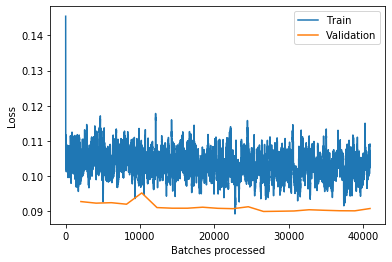

In [39]:
learn.recorder.plot_losses()

In [14]:
model_name = 'rn34-stage2-v1'
learn = learn.load(os.path.join(cfg.models_dir, model_name))

In [15]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-05


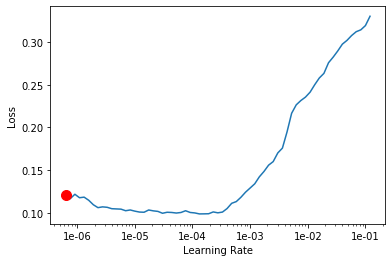

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [21]:
learn.fit_one_cycle(30, slice(1e-6, 1e-03), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn34-stage3-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.104763,0.088523,0.969159,0.956034,03:49
1,0.096687,0.086387,0.971783,0.958179,03:47
2,0.085487,0.079357,0.973431,0.961776,05:05
3,0.088659,0.076749,0.974201,0.962447,06:07
4,0.092526,0.073898,0.976955,0.963889,03:48
5,0.082003,0.072523,0.976452,0.965532,03:48
6,0.079607,0.072620,0.974850,0.966274,03:48
7,0.067666,0.067880,0.978580,0.967797,03:48
8,0.064697,0.063471,0.980136,0.969856,03:48
9,0.066733,0.063434,0.980220,0.971058,03:47


Better model found at epoch 0 with valid_loss value: 0.08852265030145645.
Better model found at epoch 1 with valid_loss value: 0.08638670295476913.
Better model found at epoch 2 with valid_loss value: 0.07935710996389389.
Better model found at epoch 3 with valid_loss value: 0.07674887776374817.
Better model found at epoch 4 with valid_loss value: 0.07389768213033676.
Better model found at epoch 5 with valid_loss value: 0.07252328842878342.
Better model found at epoch 7 with valid_loss value: 0.06788001954555511.
Better model found at epoch 8 with valid_loss value: 0.06347102671861649.
Better model found at epoch 9 with valid_loss value: 0.06343358010053635.
Better model found at epoch 10 with valid_loss value: 0.06024784967303276.
Better model found at epoch 11 with valid_loss value: 0.0550699383020401.
Better model found at epoch 12 with valid_loss value: 0.05293627828359604.
Better model found at epoch 13 with valid_loss value: 0.0511675588786602.
Better model found at epoch 15 with 

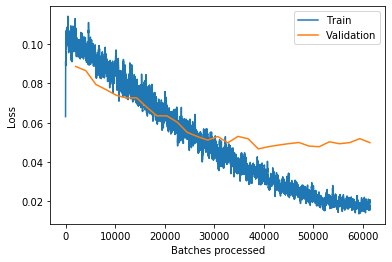

In [22]:
learn.recorder.plot_losses()

In [ ]:
learn.save(os.path.join(cfg.models_dir, 'rn34-stage1-v1'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


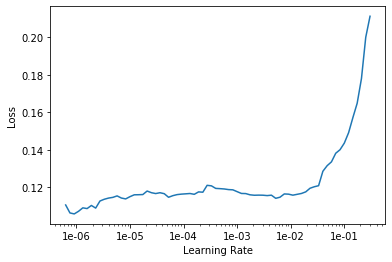

In [42]:
resnet50 = models.resnet50
learn50 = cnn_learner(data, resnet50, metrics=[acc_05, f_score])
learn.lr_find()
learn.recorder.plot()

In [43]:
lr50 = 1e-02

In [44]:
learn50.fit_one_cycle(2, slice(lr50))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.144298,0.130827,0.952186,0.938007,05:34
1,0.128029,0.109618,0.958830,0.945745,05:31


In [45]:
learn50.save(os.path.join(cfg.models_dir, 'stage-1-rn50-v3'))

In [46]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


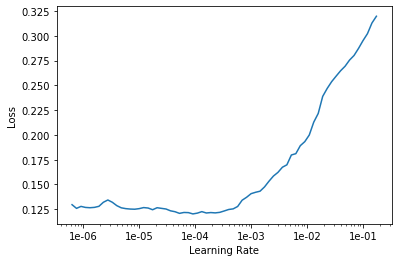

In [47]:
learn50.lr_find()
learn50.recorder.plot()

In [48]:
learn50.fit_one_cycle(5, slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137155,0.139620,0.949333,0.930537,07:53
1,0.125236,0.152772,0.960059,0.944449,07:45
2,0.091744,0.349414,0.970349,0.958063,07:46
3,0.074564,0.073083,0.979411,0.968622,07:46
4,0.063288,0.068320,0.981082,0.971431,07:46


In [49]:
learn50.save(os.path.join(cfg.models_dir, 'stage-2-rn50-v3'))

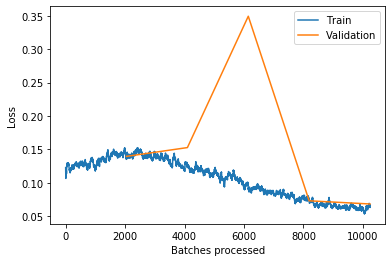

In [50]:
learn50.recorder.plot_losses()

In [51]:
learn50.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


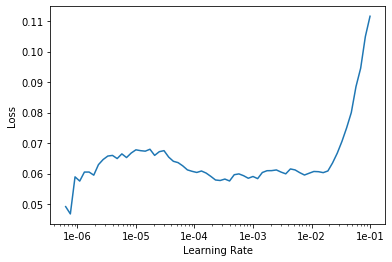

In [52]:
learn50.lr_find()
learn50.recorder.plot()

In [53]:
learn50.fit_one_cycle(2, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.072268,0.072741,0.980167,0.970301,05:27
1,0.071024,0.075032,0.981135,0.972245,05:30


In [54]:
learn50.save(os.path.join(cfg.models_dir, 'stage-3-rn50-v3'))

In [55]:
data_256 = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn50.data = data_256
data_256.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [56]:
learn50.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


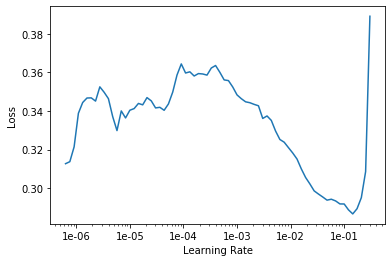

In [57]:
learn50.lr_find()
learn50.recorder.plot()

In [58]:
lr=1e-2
learn50.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124932,0.115341,0.958403,0.945981,20:52
1,0.101864,0.134240,0.966176,0.952304,20:44
2,0.096036,0.125455,0.968877,0.956562,20:31


In [59]:
learn50.save(os.path.join(cfg.models_dir, 'stage-4-256-rn50'))

In [60]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


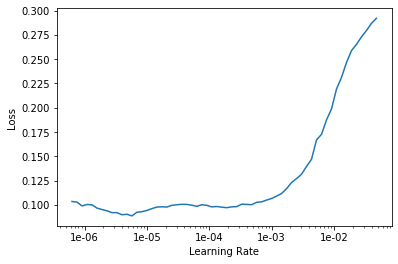

In [61]:
learn50.lr_find()
learn50.recorder.plot()

In [62]:
learn50.fit_one_cycle(2, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097339,0.083388,0.972264,0.959751,27:48
1,0.079276,0.071440,0.978870,0.968229,27:54


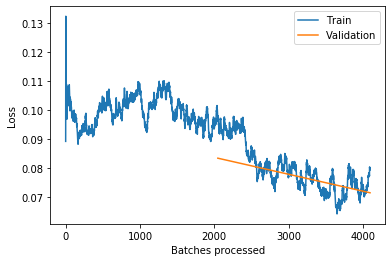

In [63]:
learn50.recorder.plot_losses()

In [64]:
learn50.save(os.path.join(cfg.models_dir, 'stage-5-256-rn50'))

In [65]:
learn50.export(os.path.join(cfg.models_dir, 'stage-5-256-rn50-exported'))